## Hypothesis:

So what are the possible patterns of a non-functional waterpoint ? 

* Location: 
    * if the waterpoint is in somewhere with very low population concentration -> no maintenance. 
    * in contrast, when it is used by a lot of people -> not enough maintenance.
    * waterpoints that are near each other are likely to have the same status.
* There might be some correlation between Quality/Cost and the functioning of a pump.
* Construction year: an old pump is more likely to have problem than a new one.
* The type of pump might be intertesting too. 



## Data cleaning

In [328]:
# -*- coding: utf-8 -*-
import re
import time
import operator
import numpy as np
import pandas as pd 
import collections
from datetime import datetime, date, timedelta
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier 

%matplotlib inline

pylab.rcParams['figure.figsize'] = 13,10

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [329]:
train_set = pd.DataFrame.from_csv('data/training_set.csv')
label_set = pd.DataFrame.from_csv('data/label_set.csv')
test_set = pd.DataFrame.from_csv('data/test_set.csv')

In [330]:
train_set.shape

(59400, 39)

We heve 59 400 data points with 40 features.

In [331]:
train_set.head(3)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [332]:
label_set.head(3)

,status_group
id,
69572,functional
8776,functional
34310,functional


Let's merge the 2 sets for easier data exploration:

In [333]:
train_set = pd.merge(train_set, label_set, left_index=True, right_index=True)

Let's check for Nan values:

In [334]:
train_set.isnull().sum(axis=0)

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

Ok so there are 7 variables with Nan values: `funder`, `installer`, `subvillage`, `public_meeting`, `scheme_management`, `scheme_name` and `permit`.

Among them, `scheme_name` is the most severe one as half of its rows are Nan.

We will thus remove it for instance. 

In [335]:
train_set = train_set.drop('scheme_name', 1)

In [336]:
test_set = test_set.drop('scheme_name',1)

In [337]:
train_set.shape

(59400, 39)

Let's take a look at other variables with missing data:

In [338]:
train_set.funder.value_counts()

Government Of Tanzania         9084
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
Kkkt                           1287
World Vision                   1246
Unicef                         1057
Tasaf                           877
District Council                843
Dhv                             829
Private Individual              826
Dwsp                            811
0                               777
Norad                           765
Germany Republi                 610
Tcrs                            602
Ministry Of Water               590
Water                           583
Dwe                             484
Netherlands                     470
Hifab                           450
Adb                             448
Lga                             442
Amref                           425
Fini Water                      393
Oxfam                           359
Wateraid                    

In [339]:
train_set.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
 1290       52
-14         51
 303        51
-18         49
-19         47
 1269       46
 1295       46
 1304       45
-23         45
 280        44
 1538       44
 1286       44
-8          44
-17         44
 1332       43
 320        43
 1317       42
 1293       42
 1319       42
 1359       42
 1264       42
 1288       42
 1401       42
 1303       42
-27         42
         ...  
 2506        1
 2023        1
-53          1
 2364        1
 2332        1
 2402        1
 2236        1
 2420        1
 2291        1
 2407        1
 2080        1
 2250        1
 591         1
 2378        1
 2535        1
 2614        1
 2484        1
 2450        1
 2072        1
 2286        1
 2567        1
 2322        1
 2254        1
 2264        1
 2464        1
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, dtype: int64

In [340]:
train_set.subvillage.value_counts()

Madukani          508
Shuleni           506
Majengo           502
Kati              373
Mtakuja           262
Sokoni            232
M                 187
Muungano          172
Mbuyuni           164
Mlimani           152
Songambele        147
Miembeni          134
Msikitini         134
1                 132
Kibaoni           114
Kanisani          111
Mapinduzi         109
I                 109
Mjini             108
Mjimwema          108
Mkwajuni          104
Mwenge            102
Mabatini           98
Azimio             98
Mission            95
Mbugani            95
Bwawani            91
Bondeni            90
Chang'Ombe         88
Zahanati           86
                 ... 
Humbo               1
Nyailungu           1
Likweje A           1
Mwamagiri           1
Bulanda             1
Rujebe              1
Kahe Ya Zamani      1
Mvumi B             1
Gumbilo B           1
Ilekebu             1
Maleti              1
Ndughwila           1
Chamwandu           1
Kwebua A            1
Nyarusonzo

In [341]:
train_set.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [342]:
train_set.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [343]:
train_set.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

We have quite a few options herer for these missing values: imputing them, replacing them with another values or dropping them. 

In our case I think that replacing them is a good option. However we won't do it right now, we will do some data exploration and consider if it is wiser to just "bundle" missing values with other values that are rare in each categorical columns. 

Let's turn the date column to data time type:

In [344]:
to_datetime = lambda raw_string: datetime.strptime(raw_string, '%Y-%m-%d').date()

In [345]:
train_set.date_recorded = train_set.date_recorded.apply(to_datetime)

In [346]:
test_set.date_recorded = test_set.date_recorded.apply(to_datetime)

Cool, now while on it, we create other columns named **recorded_year** and **Age** for the pumps too.

In [347]:
extract_year = lambda raw_datetime: raw_datetime.year

In [348]:
train_set['recorded_year'] = train_set.date_recorded.apply(extract_year)

train_set['age'] = train_set.recorded_year - train_set.construction_year

In [349]:
test_set['recorded_year'] = test_set.date_recorded.apply(extract_year)

test_set['age'] = test_set.recorded_year - test_set.construction_year

In [350]:
train_set.age

id
69572      12
8776        3
34310       4
67743      27
19728    2011
9944        2
19816    2012
54551    2012
53934    2012
46144    2011
49056       0
50409      26
36957    2012
50495       4
53752    2012
61848      20
48451      33
58155      33
34169      12
18274      19
48375       3
6091     2013
58500      33
37862       2
51058       4
22308      39
55012       2
20145    2011
19685      13
69124      11
         ... 
14796    2013
20387    2012
29940    2012
15233      25
49651    2012
50998       6
34716      23
43986    2012
38067       3
58255    2011
30647      12
67885      19
47002       5
44616       5
72148    2011
34473       1
34952       2
26640      13
72559      18
30410       2
13677      20
44885      46
40607    2011
48348    2012
11164       4
60739      14
27263      15
37057    2011
31282    2011
26348       9
Name: age, dtype: int64

Wow there is obviously a problem here: many rows have `age` very large, which means that the construction year is 0, we will need to check for 0 in construction year then. 

In [351]:
train_set.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

This will be quite troubling: we have 20709 missing values, which is almost half of our data. But this could be a very important feature, so we don't want to drop it.

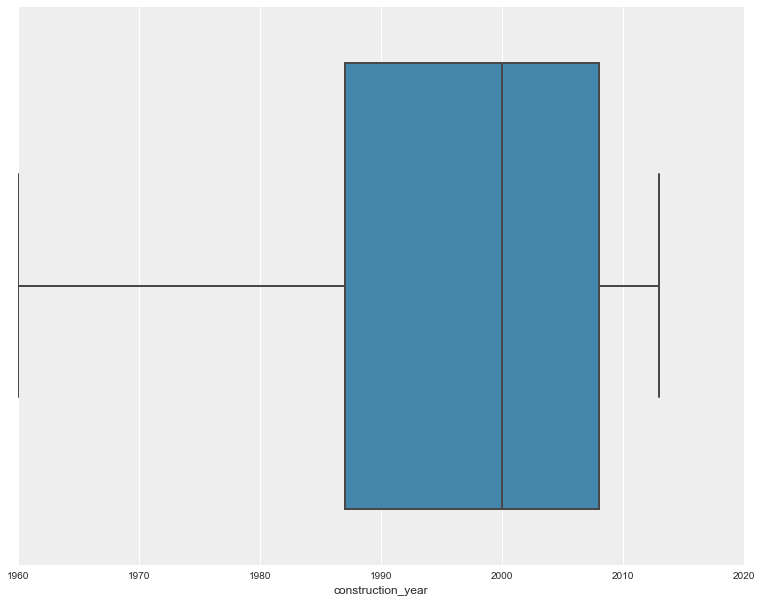

In [352]:
_=sns.boxplot(train_set[train_set.construction_year != 0].construction_year)

For now, we will replace the missing value by the median, which is 2000, but we will return to this later on the feature engineering part.

In [353]:
imp = Imputer(missing_values=0, strategy='median', axis=0)
imp.fit(train_set.construction_year.reshape(-1,1)) # the reshape part is for avoiding an annoying warning message. 

train_set.construction_year = imp.transform(train_set.construction_year.reshape(-1,1))
test_set.construction_year = imp.transform(test_set.construction_year.reshape(-1,1))

In [354]:
train_set.construction_year.value_counts()

2000.0    22800
2010.0     2645
2008.0     2613
2009.0     2533
2007.0     1587
2006.0     1471
2003.0     1286
2011.0     1256
2004.0     1123
2012.0     1084
2002.0     1075
1978.0     1037
1995.0     1014
2005.0     1011
1999.0      979
1998.0      966
1990.0      954
1985.0      945
1996.0      811
1980.0      811
1984.0      779
1982.0      744
1994.0      738
1972.0      708
1974.0      676
1997.0      644
1992.0      640
1993.0      608
2001.0      540
1988.0      521
1983.0      488
1975.0      437
1986.0      434
1976.0      414
1970.0      411
1991.0      324
1989.0      316
1987.0      302
1981.0      238
1977.0      202
1979.0      192
1973.0      184
2013.0      176
1971.0      145
1960.0      102
1967.0       88
1963.0       85
1968.0       77
1969.0       59
1964.0       40
1962.0       30
1961.0       21
1965.0       19
1966.0       17
Name: construction_year, dtype: int64

Let's recompute the `age` feature:

In [355]:
train_set['age'] = train_set.recorded_year - train_set.construction_year

In [356]:
test_set['age'] = test_set.recorded_year - test_set.construction_year

In [357]:
train_set.age.value_counts()

 11.0    14695
 12.0     5701
 13.0     4079
 3.0      2740
 1.0      2303
 2.0      2130
 5.0      1980
 4.0      1903
 7.0      1404
 6.0      1381
 14.0     1160
 8.0      1160
 33.0     1120
 15.0      993
 23.0      905
 10.0      868
 16.0      826
 9.0       814
 19.0      766
 27.0      762
 18.0      754
 28.0      709
 31.0      709
 35.0      647
 17.0      636
 39.0      601
 37.0      600
 26.0      589
 0.0       588
 25.0      583
 21.0      578
 29.0      564
 20.0      541
 41.0      488
 30.0      359
 43.0      356
 38.0      351
 36.0      325
 22.0      323
 24.0      261
 40.0      233
 34.0      184
 32.0      174
 53.0       91
 42.0       90
 50.0       84
 45.0       66
 46.0       48
 44.0       47
 48.0       41
 51.0       31
 49.0       25
 47.0       14
 52.0       11
-5.0         3
-4.0         2
-3.0         1
-7.0         1
-1.0         1
-2.0         1
Name: age, dtype: int64

We check the `population` features to see if there are any problems:

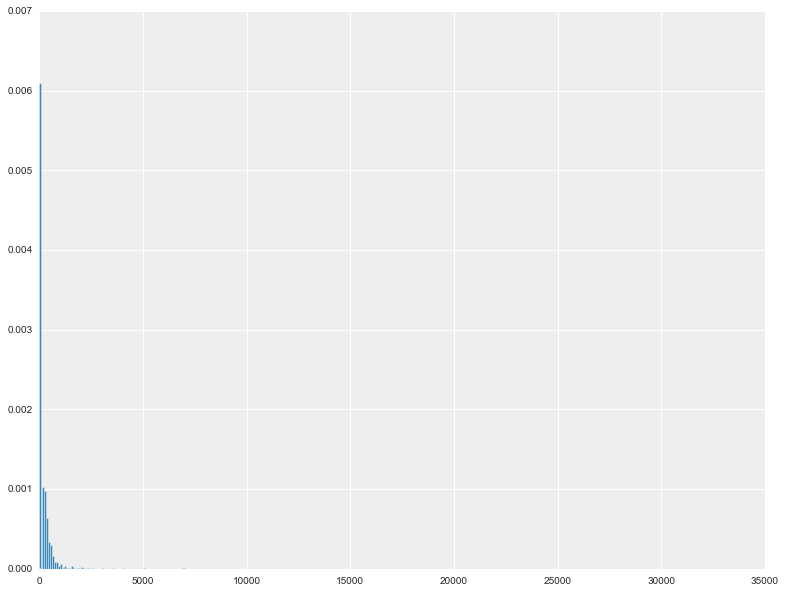

In [358]:
_=plt.hist(train_set.population, bins = np.arange(min(train_set.population), max(train_set.population),100), normed=True)

There are a lot of values "0", for now we replace them by the mean.

In [359]:
imp = Imputer(missing_values=0, strategy='mean', axis=0)
imp.fit(train_set.population.reshape(-1,1)) # the reshape part is for avoiding an annoying warning message. 

train_set.population = imp.transform(train_set.population.reshape(-1,1))
test_set.population = imp.transform(test_set.population.reshape(-1,1))

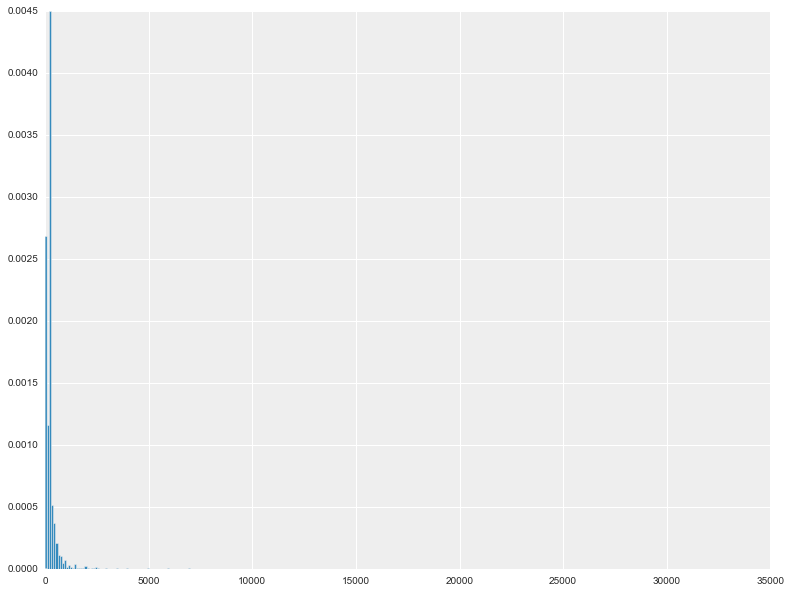

In [360]:
_=plt.hist(train_set.population, bins = np.arange(min(train_set.population), max(train_set.population),100), normed=True)

In [361]:
train_set.columns

Index([u'amount_tsh', u'date_recorded', u'funder', u'gps_height', u'installer',
       u'longitude', u'latitude', u'wpt_name', u'num_private', u'basin',
       u'subvillage', u'region', u'region_code', u'district_code', u'lga',
       u'ward', u'population', u'public_meeting', u'recorded_by',
       u'scheme_management', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group', u'status_group', u'recorded_year', u'age'],
      dtype='object')

## Exploratory Data Analyses

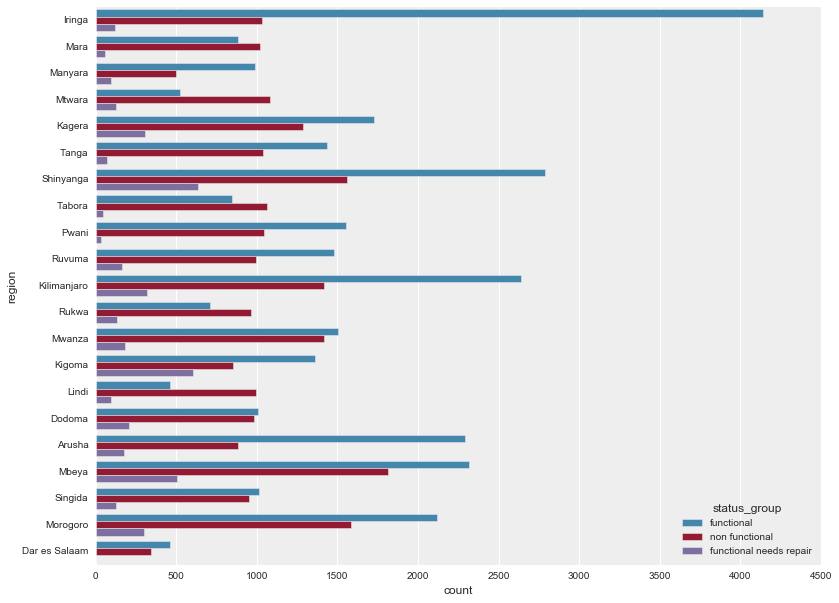

In [362]:
sns.countplot(y='region', data=train_set, hue='status_group')

Most of the region have more functioning waterpoints than broken ones, except some (Mara, Mtwara, Tabora...)

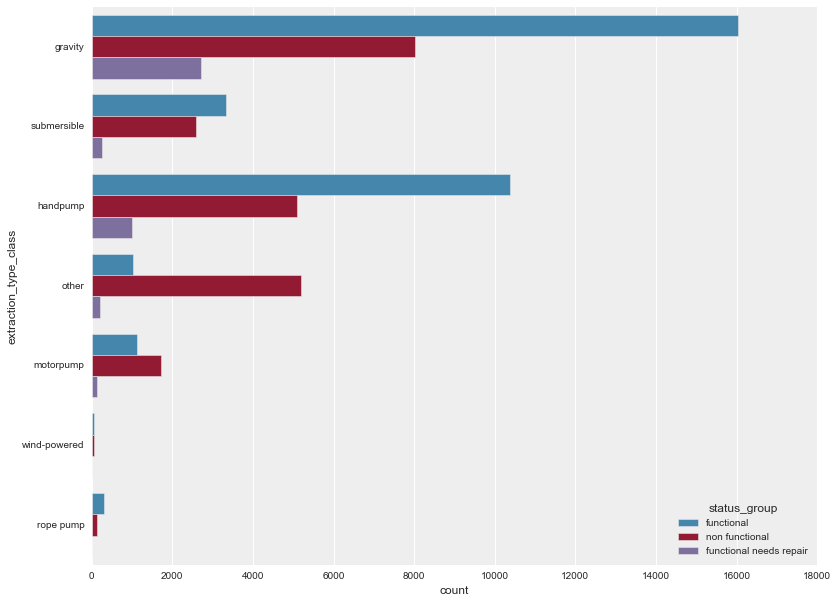

In [363]:
sns.countplot(y=train_set.extraction_type_class, hue= train_set.status_group)

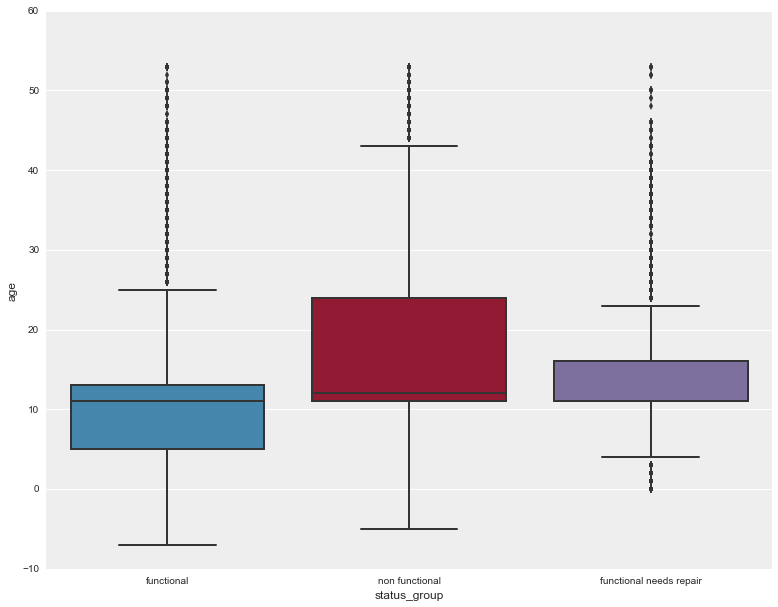

In [364]:
sns.boxplot(x=train_set.status_group, y=train_set.age)

Old pumps are more likely to have problems than the new ones.

In [365]:
train_set.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

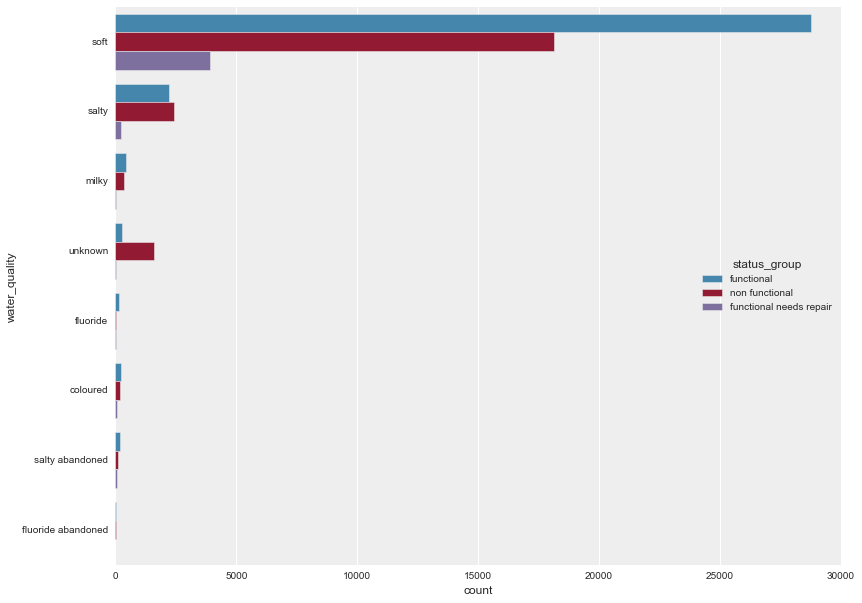

In [366]:
sns.countplot(y=train_set.water_quality, hue=train_set.status_group)

In [367]:
train_set.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

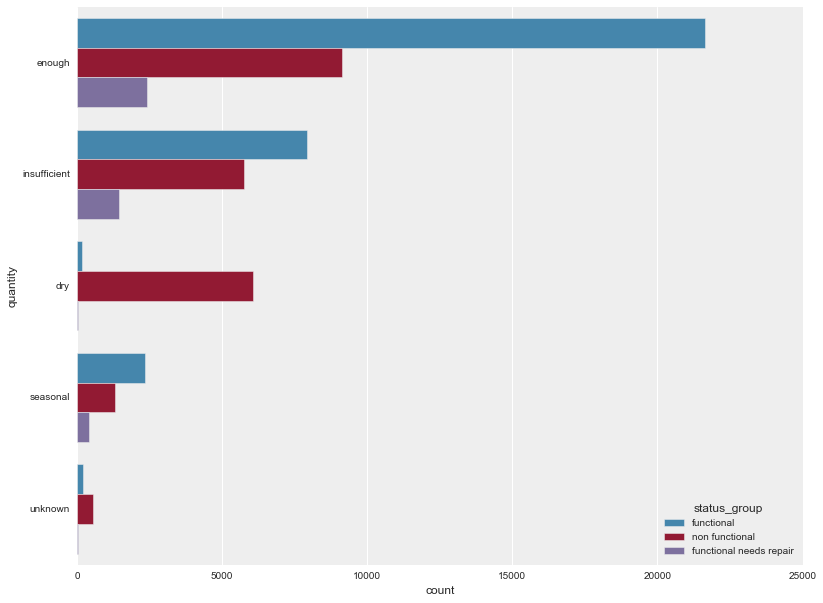

In [368]:
sns.countplot(y=train_set.quantity, hue=train_set.status_group)

In [369]:
train_set.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

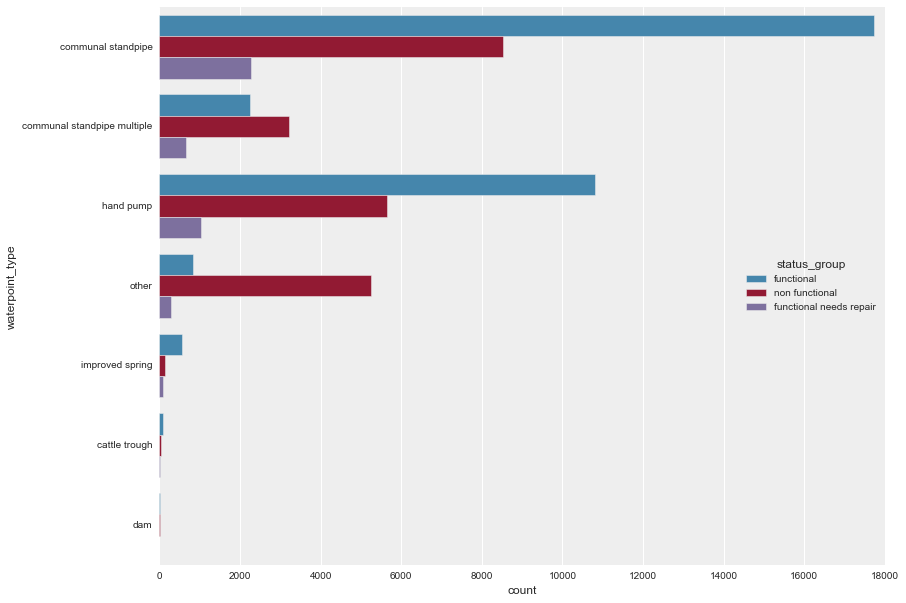

In [370]:
sns.countplot(y=train_set.waterpoint_type, hue=train_set.status_group)

In [371]:
train_set.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

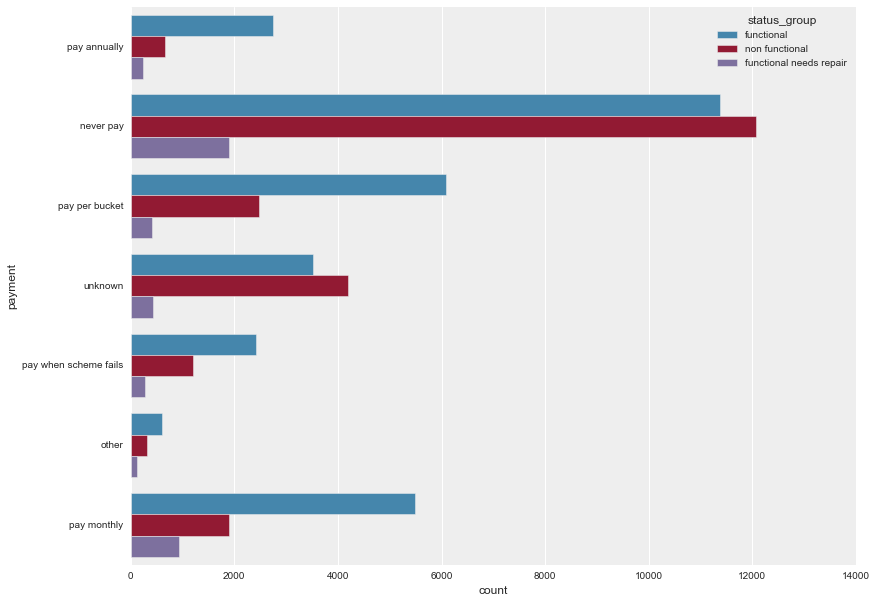

In [372]:
sns.countplot(y=train_set.payment, hue=train_set.status_group)

## Model

In [373]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 41 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null float64
public_meeting           56066 non-null object
recorded_by              59400 non-null o

In [421]:
drop_list = ['ward','subvillage','wpt_name','installer','funder', 'date_recorded', 'num_private', 'region','extraction_type_class', 
             'extraction_type_group', 'recorded_year', 'construction_year', 'source', 'source_class', 'quality_group', 'quantity_group', 
             'payment', 'management_group','waterpoint_type_group', 'public_meeting']

In [422]:
train = train_set.drop(drop_list, axis=1)

In [423]:
test = test_set.drop(drop_list, axis=1)

In [424]:
train_set.public_meeting.unique()

array([True, nan, False], dtype=object)

In [425]:
test_set.public_meeting.unique()

array([True, nan, False], dtype=object)

Now we create a function to encode categorical label into numerical value.

In [428]:
def encode_label(train_df, test_df):
    
    new_train_df = train_df.copy()
    new_test_df = test_df.copy()
    
    df_col = new_train_df.columns.tolist()
    
    for col in df_col:
        if new_train_df[col].dtypes == object:
            le = preprocessing.LabelEncoder()
            new_train_df[col] = le.fit_transform(new_train_df[col])
            if col != 'status_group':
                new_test_df[col] = le.transform(new_test_df[col])
                
    return new_train_df, new_test_df

In [429]:
train_df, test_df = encode_label(train, test)

In [436]:
train_df.status_group.value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [437]:
train_set.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'], dtype=object)

In [438]:
convert_label = lambda x: 'functional' if x == 0 else 'non functional' if x == 2 else 'functional needs repair'

Ok, let's build a quick model:

In [430]:
feature_list = [col for col in train_df.columns if col != 'status_group']

In [431]:
clf = RandomForestClassifier(n_estimators=500)

In [299]:
error = cross_validation.cross_val_score(clf, train_df[feature_list], train_df['status_group'], 
                                         scoring='accuracy', cv=10, verbose=1 )

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.1min finished


In [300]:
error

array([ 0.81720249,  0.82023228,  0.81720249,  0.80609325,  0.82457912,
        0.81178451,  0.81599327,  0.80619633,  0.80518606,  0.82199394])

In [432]:
clf.fit(train_df[feature_list], train_df['status_group'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [433]:
prediction = clf.predict(test_df[feature_list])

In [443]:
prediction_label = map(convert_label, prediction)

In [444]:
prediction_label

['non functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional needs repair',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional needs repair',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'non functional',
 'functional needs repair',
 'non 

In [447]:
result = test.copy()

In [448]:
result['status_group'] = prediction_label

In [455]:
result = result.loc[:,['status_group']]

In [456]:
result.to_csv('submission.csv')